# Projet 9: Réalisez une application de recommandation de contenu

Contexte : My Content est une start-up engagée à encourager la lecture en recommandant des livres qui captiveront les lecteurs. Dans un premier temps, le start-up souhaite tester une solution de recommandation d’articles et de livres à des particuliers.

Pour relever ce défi, nous devons :

    Tester différentes approches de modélisation pour la recommandation des articles

    Définir une architecture technique pour concevons une application de recommandation reposant sur une architecture serverless

    Réaliser une application simple de gestion du système de recommandation 

    Définir un architecture cible pour pouvoir prendre en compte l’ajout de nouveaux utilisateurs ou de nouveaux articles


### Sommaire
1. [Description des données](#paragraph1) </p>
2. [Filtrage basé sur le contenu](#paragraph2)</p>
3. [Filtrage collaboratif](#paragraph3)</p>    


In [73]:
import pandas as pd
from pandas.api.types import is_numeric_dtype  # Import the function
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import StandardScaler

from surprise import Dataset,Reader,SVD,KNNWithMeans


from surprise.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split,
)

from scipy import sparse
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import OrdinalEncoder  # Import OrdinalEncoder

import pickle
import joblib

## 1. Description des données<a class="anchor" id="paragraph1"></a>

In [74]:
DATA_PATH = "D:/openclassroom/projet9/input/news-portal-user-interactions-by-globocom/"


In [75]:
NUM_EMBEDDINGS = 250
articles_metadata = pd.read_csv(DATA_PATH + "articles_metadata.csv")
articles_embeddings = pd.DataFrame(pd.read_pickle(DATA_PATH + "articles_embeddings.pickle"),columns=["embedding_" + str(i) for i in range(NUM_EMBEDDINGS)])
df_articles = pd.concat([articles_metadata,articles_embeddings],axis=1)
df_articles = df_articles.astype({"created_at_ts": "datetime64[ns]"})

In [76]:
df_articles.head()

,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,0,0,1970-01-01 00:25:13.144419,0,168,-0.161183,-0.957233,-0.137944,0.050855,0.830055,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,1,1970-01-01 00:23:25.341936,0,189,-0.523216,-0.974058,0.738608,0.155234,0.626294,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,1,1970-01-01 00:23:28.667706,0,250,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,1,1970-01-01 00:23:28.468313,0,230,-0.740843,-0.975749,0.391698,0.641738,-0.268645,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,1,1970-01-01 00:23:27.071171,0,162,-0.279052,-0.972315,0.685374,0.113056,0.238315,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [77]:
articles_ids = df_articles[["article_id","category_id"]]

In [78]:
articles_ids.head()

,article_id,category_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [79]:
articles_ids.to_csv("C:/Users/doly9/Projet9-Realisez-une-application-de-recommandation-de-contenu/articles_ids.csv",sep=";", index=False)

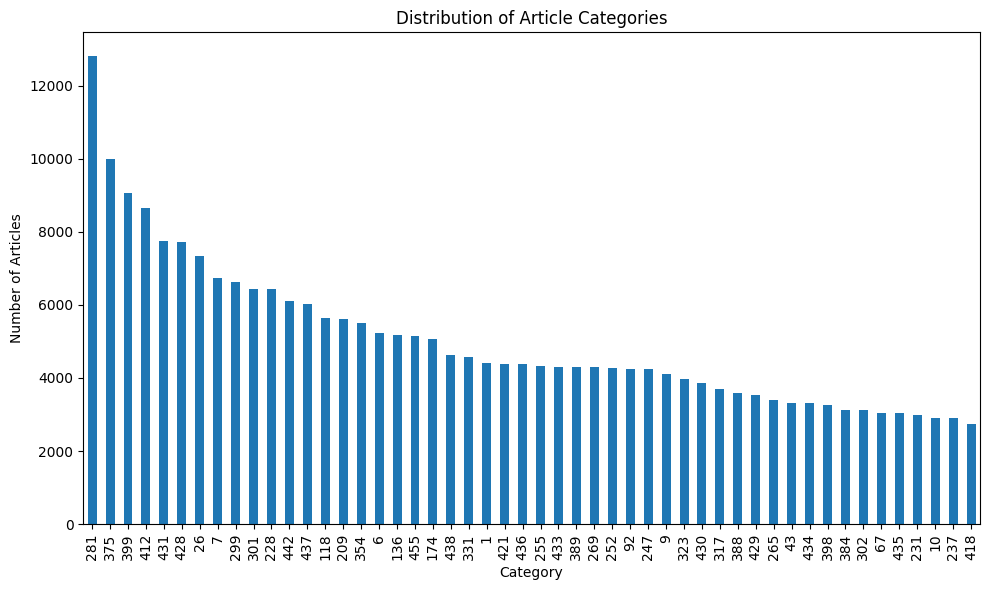

In [80]:
## Visualize Articles Categories distribution

# Group the DataFrame by 'category' and count the number of articles in each category
category_counts = articles_metadata['category_id'].value_counts()[0:50]

# Create a bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Article Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

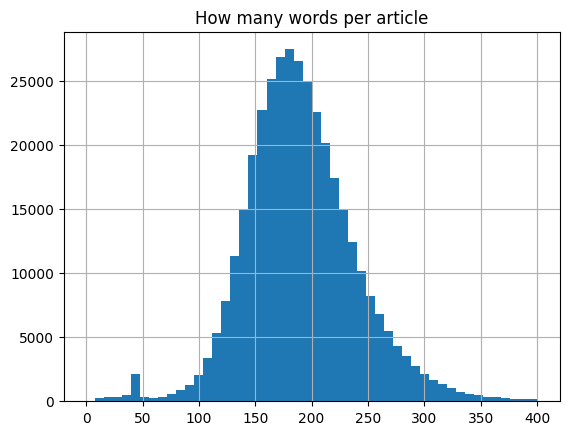

In [81]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

In [82]:
df_clicks = pd.concat(
    [
        pd.read_csv(
            click_file_path)
        for click_file_path in sorted(Path(DATA_PATH, "clicks/clicks").glob("clicks_hour_*.csv"))
    ],
    sort=False,
    ignore_index=True,
    verify_integrity=True,
)

df_clicks = df_clicks.astype(
    {"session_start": "datetime64[ns]", "click_timestamp": "datetime64[ns]"}
)


In [83]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1970-01-01 00:25:06.825423,2,157541,1970-01-01 00:25:06.826828020,4,3,20,1,20,2
1,0,1506825423271737,1970-01-01 00:25:06.825423,2,68866,1970-01-01 00:25:06.826858020,4,3,20,1,20,2
2,1,1506825426267738,1970-01-01 00:25:06.825426,2,235840,1970-01-01 00:25:06.827017951,4,1,17,1,16,2
3,1,1506825426267738,1970-01-01 00:25:06.825426,2,96663,1970-01-01 00:25:06.827047951,4,1,17,1,16,2
4,2,1506825435299739,1970-01-01 00:25:06.825435,2,119592,1970-01-01 00:25:06.827090575,4,1,17,1,24,2


In [84]:
df_clicks.shape

(2988181, 12)

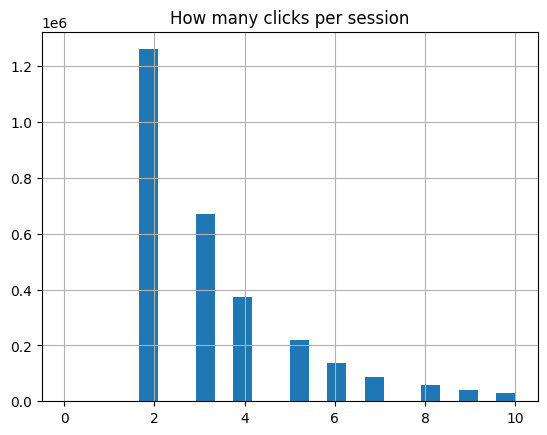

In [85]:
df_clicks.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session');

## 3. Filtrage basé sur le contenu<a class="anchor" id="paragraph2"></a>

Recommande des éléments similaires en se basant sur des caractéristiques du contenu.

Efficace pour recommander des éléments similaires en fonction de leurs caractéristiques, mais peut manquer de découverte de nouvelles recommandations en dehors des préférences connues.


Calcul la similarité cosinus entre les préférences de l'utilisateur et les articles
   
   Préférences(user,article)=  #Clicks(user,article) /#Clicks(user) 


In [86]:
def aggregate_articles(articles):
    return articles.groupby(lambda x: True).agg(
        {
            col: "mean"
            if is_numeric_dtype(articles.dtypes[col])
            else lambda x: x.mode()[0]
            for col in articles.columns
        }
    )


def get_user_interest(user_id, clicks, articles):
    all_article_ids = clicks.query("user_id == @user_id")["click_article_id"]
    interest = aggregate_articles(articles.query("article_id in @all_article_ids")).drop(["article_id"], axis=1)
    return interest



In [87]:
user_id = 100
interest = get_user_interest(user_id, df_clicks, df_articles)
interest

,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
True,340.4,1970-01-01 00:25:06.770125,0.0,194.2,-0.495968,-0.970604,0.25876,-0.378692,-0.275372,-0.036043,...,-0.344387,-0.031984,-0.550287,0.353212,0.003794,-0.139346,0.260136,0.235911,0.261088,0.243127


**Calculer la similarité cosinus (cosine_similarity) entre le profil utilisateur et les articles**

Les caractéristiques avec des échelles différentes peuvent avoir un impact disproportionné sur la mesure de similarité. En normalisant les données, on se assure que toutes les caractéristiques ont la même importance dans le calcul de la similarité


In [88]:
def normalize_data(interest, articles):
    articles_copy = articles.copy()
    articles_copy["created_at_ts"] = articles["created_at_ts"].apply(lambda x: x.value)
    articles_copy = articles_copy.drop(["article_id"], axis=1, errors="ignore")
    interest_copy = interest.copy()
    interest_copy["created_at_ts"] = interest_copy["created_at_ts"].apply(lambda x: x.value)
    # Créez le scaler et normalisez le DataFrame
    scaler = StandardScaler()
    articles_std = scaler.fit_transform(articles_copy)
    interest_std = scaler.transform(interest_copy)
    
    return interest_std, articles_std


def get_closest_articles(user_id, clicks, articles, n=10):
    
    interest = get_user_interest(user_id, clicks, articles)
    interest_std, articles_std = normalize_data(interest, articles)
    articles["similarity"] = cosine_similarity(interest_std, articles_std)[0]
    closest_articles = articles.sort_values("similarity", ascending=False).iloc[:n]
    
    return closest_articles


In [89]:
closest_articles = get_closest_articles(12, df_clicks, df_articles)
closest_articles


C:\Users\doly9\AppData\Local\Temp\ipykernel_10124\2784332478.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  articles["similarity"] = cosine_similarity(interest_std, articles_std)[0]


,article_id,category_id,created_at_ts,publisher_id,words_count,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,similarity
282957,282957,412,1970-01-01 00:25:01.535560,0,194,-0.606592,-0.976242,-0.467239,-0.760416,-0.840716,...,-0.514539,-0.743506,-0.330946,0.128643,0.148477,-0.417433,0.459697,0.671064,0.284426,0.760103
284482,284482,412,1970-01-01 00:25:04.106264,0,200,-0.680650,-0.972817,-0.818285,-0.834580,-0.830102,...,-0.084912,-0.640432,-0.137516,0.448036,-0.277606,-0.308908,0.255684,0.466560,0.507776,0.744655
345462,345462,440,1970-01-01 00:25:12.895631,0,215,-0.564753,-0.974516,-0.721140,-0.706770,-0.883753,...,-0.001318,-0.424073,0.223282,0.573188,0.377278,-0.491625,0.844249,0.486018,0.787883,0.739269
345895,345895,440,1970-01-01 00:25:14.014171,0,157,-0.581047,-0.974149,-0.777072,-0.940099,-0.773101,...,-0.217159,-0.686530,0.179895,0.594134,0.723309,-0.342652,0.782238,0.367197,0.761838,0.733492
345082,345082,440,1970-01-01 00:25:13.333642,0,195,-0.195791,-0.965950,-0.114532,-0.781894,-0.834506,...,-0.672720,-0.452699,-0.084850,0.682785,0.561939,0.279603,0.672175,0.339436,0.836625,0.731206
286311,286311,412,1970-01-01 00:25:05.973662,0,244,-0.592960,-0.976845,-0.689005,-0.837854,-0.578759,...,0.123582,-0.691316,-0.148304,0.620894,0.443892,-0.632522,0.678047,0.044443,0.723896,0.725237
284180,284180,412,1970-01-01 00:25:04.975205,0,184,-0.794885,-0.968676,-0.886317,-0.882009,-0.710047,...,-0.069468,-0.605709,-0.060278,0.490093,0.290156,0.105901,-0.002429,0.445593,0.797931,0.724819
284198,284198,412,1970-01-01 00:25:02.949695,0,180,-0.782668,-0.963300,-0.734844,-0.822006,-0.791198,...,-0.271158,-0.643646,0.296126,0.683172,0.503872,-0.384119,0.418132,0.359256,0.694264,0.714154
284202,284202,412,1970-01-01 00:25:10.763824,0,209,-0.801270,-0.975783,-0.663255,-0.959221,-0.797305,...,-0.365099,-0.467464,-0.311559,0.272786,0.681702,-0.466372,0.597639,-0.108126,0.598610,0.713084
345826,345826,440,1970-01-01 00:25:13.400459,0,243,-0.513355,-0.974253,-0.653996,-0.799129,-0.592877,...,-0.686625,-0.651551,-0.366320,0.587387,0.556407,-0.571241,-0.098135,0.380057,0.758900,0.712443


## 3. Filtrage collaboratif<a class="anchor" id="paragraph3"></a>

Recommande des éléments en se basant sur les comportements passés et les préférences d'autres utilisateurs.

Efficace pour découvrir de nouvelles recommandations en fonction du comportement des utilisateurs similaires, mais peut rencontrer des difficultés avec de nouveaux utilisateurs ou des données de préférences limitées.


- Bibliothèque : Implicit

    L'algorithme Alternating Least Squares (ALS) est une technique de factorisation matricielle utilisée pour décomposer une matrice de données en deux matrices de facteurs latents, une pour les utilisateurs et une pour les éléments (articles, produits, etc)
    ALS est particulièrement bien adapté aux données creuses

- Bibliothèque : Surpris

    SVD (Singular Value Decomposition) est une méthode de décomposition matricielle qui décompose une matrice en trois matrices : une matrice U pour les utilisateurs, une matrice Σ pour les valeurs singulières, et une matrice V pour les éléments. 

    SVD fonctionne mieux avec des matrices de données complètes et denses



### Surprise: SVD  -  Algorithme de factorisation matricielle

**Création de la matrice user-rating**

In [90]:
def calculate_ratings_from_clicks(clicks):
    # Calcul du nombre de clics par utilisateur et par article
    user_article_click_counts = clicks.groupby(["user_id", "click_article_id"]).size().reset_index(name="click_count")

    # Calcul du nombre total de clics par utilisateur
    user_click_counts = clicks.groupby(["user_id"]).size().reset_index(name="total_clicks")

    # Fusion des données pour calculer les évaluations
    ratings = user_article_click_counts.merge(user_click_counts, on="user_id")
    ratings["rating"] = ratings["click_count"] / ratings["total_clicks"]

    
    ratings = ratings.drop(["click_count","total_clicks"],axis=1)
    ratings = ratings.rename(columns={"click_article_id": "article_id"})

    return ratings


In [91]:
ratings = calculate_ratings_from_clicks(df_clicks)
ratings

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125
...,...,...,...
2950705,322894,168401,0.500
2950706,322895,63746,0.500
2950707,322895,289197,0.500
2950708,322896,30760,0.500


**Effectuer la recherche des meilleurs parametres sur la grille**

In [92]:
sample_frac = 0.1
reader = Reader(rating_scale=(0, 1))
# Charger les données à partir de l'échantillon
data = Dataset.load_from_df(ratings.sample(frac=sample_frac, random_state=42), reader)

# Grille de paramètres à rechercher
param_grid = {
    "n_epochs": [20, 50, 100],  # Nombre d'époques d'entraînement
    "lr_all": [0.005, 0.01, 0.02],  # Taux d'apprentissage
    "reg_all": [0.02, 0.05, 0.1],  # Terme de régularisation
}


# Créer une instance de GridSearchCV avec SVD comme algorithme à rechercher
grid = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"],  # Mesures de performance à évaluer
    cv=3, 
    refit=True,  # Réajuster le modèle avec les meilleurs paramètres
    return_train_measures=True,  # Retourner les mesures sur l'ensemble d'entraînement
    n_jobs=-2,  # Utiliser tous les cœurs disponibles, sauf un
    joblib_verbose=9,  # Afficher les détails de la recherche
)

# Effectuer la recherche sur la grille
grid.fit(data)

# Meilleur score RMSE
print("Meilleur score RMSE:", grid.best_score["rmse"])

# Combinaison de paramètres donnant le meilleur score RMSE
print("Meilleurs paramètres RMSE:", grid.best_params["rmse"])



[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done  70 out of  81 | elapsed:  2.0min remaining:   18.7s
[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed:  2.3min finished


Meilleur score RMSE: 0.10661019003259382
Meilleurs paramètres RMSE: {'n_epochs': 100, 'lr_all': 0.02, 'reg_all': 0.05}


In [93]:
best_params = grid.best_params["rmse"]

# Load the dataset
data = Dataset.load_from_df(ratings, reader)

# Build the full training set (no splitting)
trainset = data.build_full_trainset()

# Initialize and train the SVD model with the best hyperparameters
best_svd = SVD(**best_params, random_state=42, verbose=True)
best_svd.fit(trainset)

cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

{'test_rmse': array([0.12732622, 0.12734887, 0.12757196]),
 'test_mae': array([0.10398683, 0.10405373, 0.1041454 ]),
 'fit_time': (112.52210140228271, 117.17257571220398, 110.61040902137756),
 'test_time': (8.142285585403442, 7.984655141830444, 8.29068922996521)}

**On a engristré un modèle SVD plus léger pour tester l'application**

In [68]:
ratings_sample = ratings.iloc[0:3000,]
reader = Reader(rating_scale=(0, 1))
# Charger les données à partir de l'échantillon
data = Dataset.load_from_df(ratings_sample, reader)
# Build the full training set (no splitting)
trainset = data.build_full_trainset()

In [69]:
from surprise.dump import dump

# Specify a file name with a valid extension (e.g., 'svd_model.pkl')
model_file_path = 'C:/Users/doly9/Projet9-Realisez-une-application-de-recommandation-de-contenu/svd_model.pkl'
model = SVD()
model.fit(trainset)
# Save the model
#dump(model_file_path, algo=best_svd)
joblib.dump(model,model_file_path)

['C:/Users/doly9/Projet9-Realisez-une-application-de-recommandation-de-contenu/svd_model.pkl']

In [70]:
import joblib
model = joblib.load(model_file_path)

In [65]:
def get_collaborative_reco(user_id, model, articles_df, n=10):
    # Predict ratings for all articles for the given user
    predictions = [
        model.predict(uid=user_id, iid=article_id) for article_id in articles_df["article_id"]
    ]

    # Create a DataFrame from the predictions
    prediction_df = pd.DataFrame(predictions, columns=["uid", "iid", "rating", "est", "details"])
    print(prediction_df)

    # Sort the DataFrame by predicted rating in descending order
    sorted_df = prediction_df.sort_values(by="est", ascending=False)

    # Get the top N article IDs
    top_n_article_ids = sorted_df["iid"].head(n).tolist()

    return top_n_article_ids


In [66]:
user_id = "5890"
closest_article_ids = get_collaborative_reco(user_id, model, articles_ids)

         uid     iid rating       est                    details
0       5890       0   None  0.036407  {'was_impossible': False}
1       5890       1   None  0.036407  {'was_impossible': False}
2       5890       2   None  0.036407  {'was_impossible': False}
3       5890       3   None  0.036407  {'was_impossible': False}
4       5890       4   None  0.036407  {'was_impossible': False}
...      ...     ...    ...       ...                        ...
364042  5890  364042   None  0.036407  {'was_impossible': False}
364043  5890  364043   None  0.036407  {'was_impossible': False}
364044  5890  364044   None  0.036407  {'was_impossible': False}
364045  5890  364045   None  0.036407  {'was_impossible': False}
364046  5890  364046   None  0.036407  {'was_impossible': False}

[364047 rows x 5 columns]


In [67]:
closest_article_ids

[108854, 145166, 338013, 288431, 96663, 284845, 209348, 119592, 235840, 157541]

### Surprise: KNN

In [52]:
# Define the reader and load the dataset
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(ratings, reader)

# Define the similarity options
sim_options = {
    "name": ["cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

# Define the parameter grid
param_grid = {
    "sim_options": sim_options,
    "k": [5, 10],
    "min_k": [2, 3],
}

# Initialize GridSearchCV with KNNWithMeans
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)

# Fit the grid search on the data
gs.fit(data)


Computing the cosine similarity matrix...


MemoryError: Unable to allocate 10.3 GiB for an array with shape (37141, 37141) and data type float64

## Librairie Implicit: ALS


L'algorithme Alternating Least Squares (ALS) est un algorithme de factorisation matricielle utilisé dans les systèmes de recommandation pour modéliser les interactions entre utilisateurs et articles. Il est couramment utilisé pour les systèmes de recommandation basés sur la rétroaction implicite, où les interactions entre utilisateurs et articles sont représentées par des données implicites telles que des clics, des vues, des achats, etc.

L'objectif principal de l'ALS est de minimiser la somme des carrés des erreurs entre la matrice d'interactions réelle et la matrice reconstruite à partir des matrices de facteurs latents. Cela revient à trouver les matrices de facteurs latents qui permettent de mieux modéliser les interactions observées

**Voici comment construire un système de recommandation avec ALS:**

1. Encodage des données :

Encodez les identifiants d'utilisateurs et d'éléments en tant qu'indices entiers, car ALS fonctionne généralement avec des indices basés sur des entiers. On peut  utiliser la classe sklearn.preprocessing.OrdinalEncoder à cet effet.

2. Création d'une matrice utilisateur-élément sparse :

Construisez une matrice utilisateur-élément sparse où les lignes représentent les utilisateurs, les colonnes représentent les éléments et les valeurs représentent les forces d'interaction utilisateur-élément. Cette matrice doit être clairsemée car la plupart des interactions sont manquantes (rétroaction implicite).

3. Formation du modèle ALS :

Initialisez un modèle ALS 
Entraînez le modèle en utilisant la matrice utilisateur-élément sparse.

4. Génération de recommandations :


In [20]:
# Create a sparse matrix from the encoded data
ratings_sparse = sparse.csr_matrix((ratings["rating"], (ratings["user_id"], ratings["article_id"])))

# Initialize and train the Alternating Least Squares (ALS) model
model_als = AlternatingLeastSquares()
model_als.fit(ratings_sparse)

C:\Users\doly9\Anaconda3\envs\envProject9\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
 87%|████████▋ | 13/15 [05:39<00:52, 26.09s/it]


KeyboardInterrupt: 

In [ ]:
def get_collaborative_recommendations(user_id, model, ratings_sparse, n=10):
    """
    Get collaborative filtering recommendations for a user.

    Args:
        user_id (int): The index of the user for whom recommendations are requested.
        model: The trained collaborative filtering model (e.g., ALS).
        ratings_sparse (scipy.sparse.csr_matrix): The user-item interaction matrix.
        n (int, optional): The number of recommendations to return. Default is 10.

    Returns:
        list: A list of recommended article indices.
    """
    # Get recommended article indices for the user
    recommended_article_indices, _ = model.recommend(
        user_id,
        ratings_sparse[user_id],
        N=n,
        filter_already_liked_items=False,
    )

    return recommended_article_indices


In [71]:
user_id = 5890

closest_article_id = get_collaborative_reco(user_id, model, ratings_sparse)
closest_article_id

array([30917, 17276, 17782, 38021, 31179, 35378, 17796, 42587, 21161,
        8499])

In [ ]:


# Define the file path where you want to save the model
model_file_path = 'ALS_model.pkl'

# Save the model using pickle
with open("C:/Users/doly9/Projet9-Realisez-une-application-de-recommandation-de-contenu/", 'wb') as model_file:
    pickle.dump(model, model_file)